### This is the best mlp model at this time !



Best Hyperparameters:
num_layers: 3
units: 512
dropout_rate: 0.20502924726067387
learning_rate: 0.00021543090477964383
l1_reg: 4.1546327889531985e-05
l2_reg: 1.4496373911843364e-07
epochs: 350
batch_size: 32

Fold 1
Epoch 1/350
345/345 [==============================] - 17s 37ms/step - loss: 4.9356 - accuracy: 0.1094 - val_loss: 4.3826 - val_accuracy: 0.1722 - lr: 2.1543e-04
Epoch 2/350
345/345 [==============================] - 10s 29ms/step - loss: 3.6768 - accuracy: 0.2468 - val_loss: 2.8784 - val_accuracy: 0.4348 - lr: 2.1543e-04
Epoch 3/350
345/345 [==============================] - 7s 22ms/step - loss: 3.2184 - accuracy: 0.3296 - val_loss: 2.5539 - val_accuracy: 0.5053 - lr: 2.1543e-04
Epoch 4/350
345/345 [==============================] - 7s 21ms/step - loss: 2.9522 - accuracy: 0.3776 - val_loss: 2.3473 - val_accuracy: 0.5623 - lr: 2.1543e-04
Epoch 5/350
345/345 [==============================] - 8s 23ms/step - loss: 2.7587 - accuracy: 0.4187 - val_loss: 2.2150 - val_accuracy: 

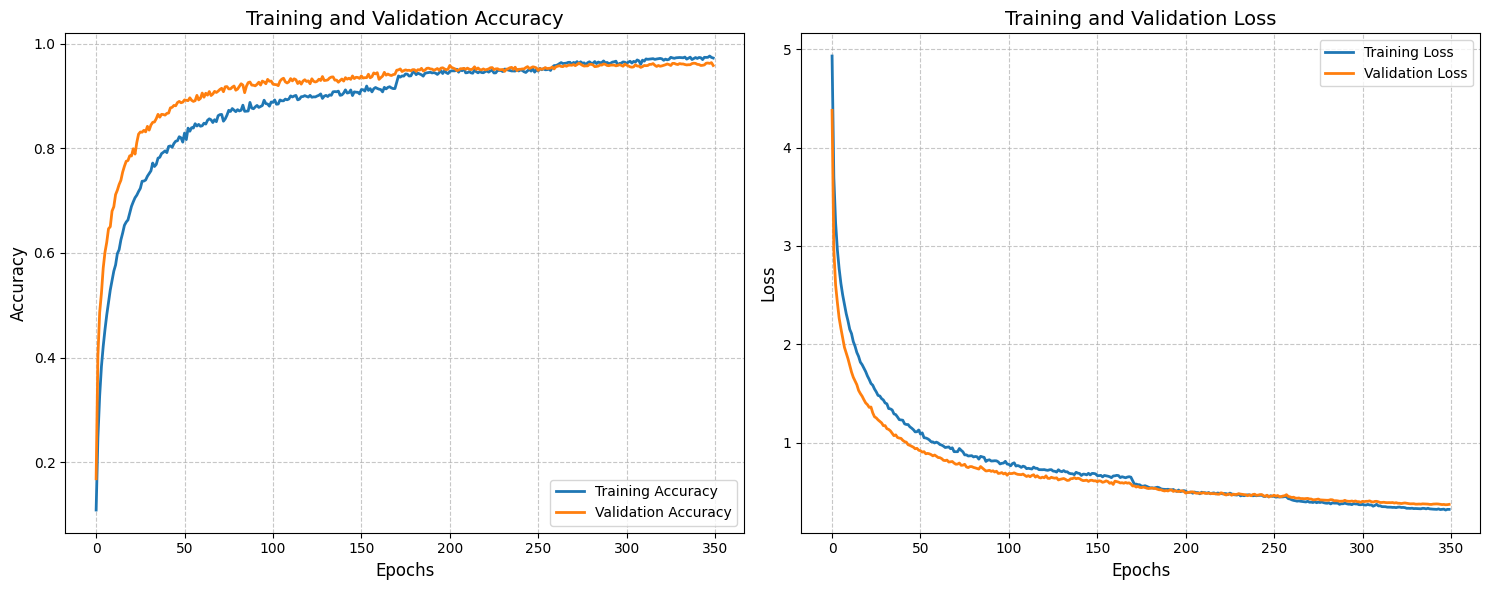


Test Accuracy: 0.9544
Train Accuracy: 0.9880
108/108 [==============================] - 1s 3ms/step
Test F1-score: 0.9534
Test Precision: 0.9564
Test Recall: 0.9544


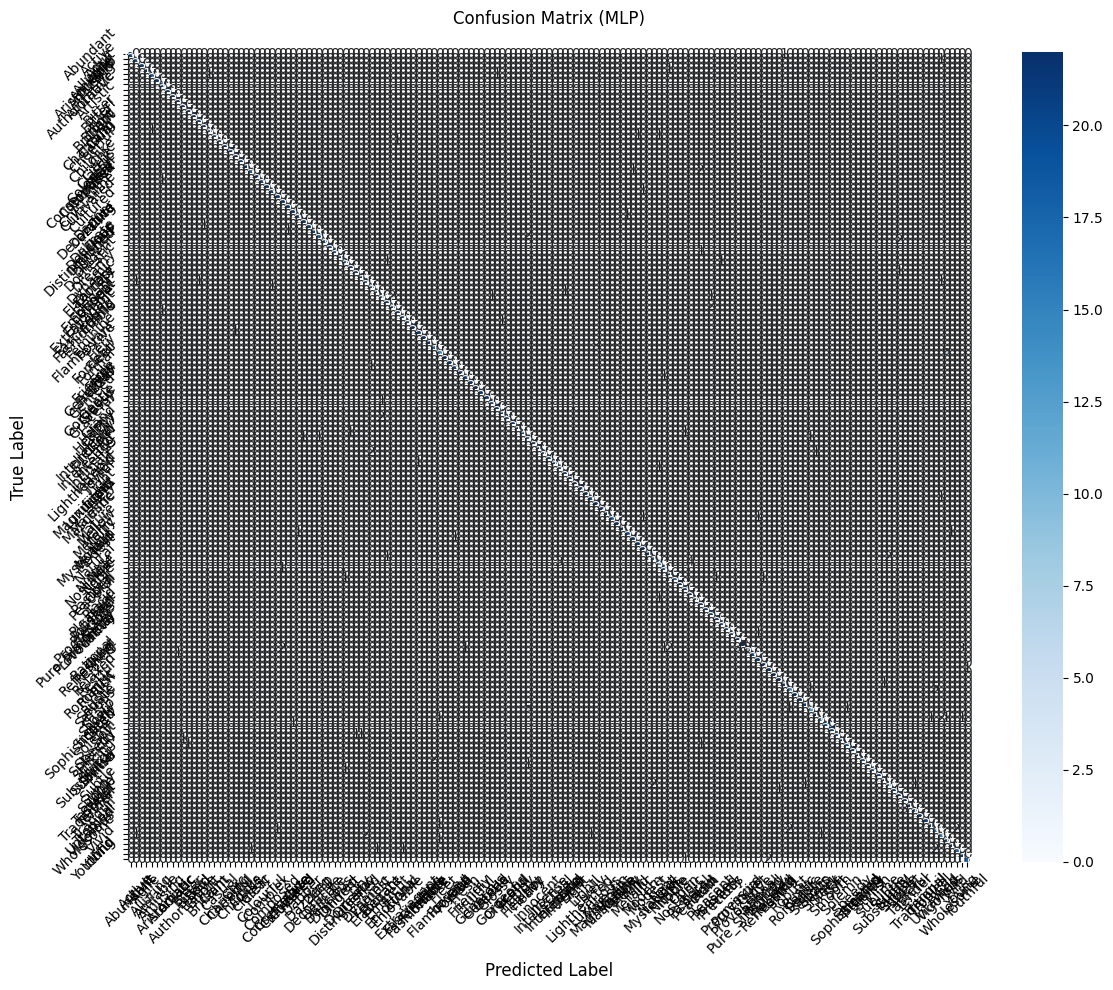

108/108 [==============================] - 0s 4ms/step


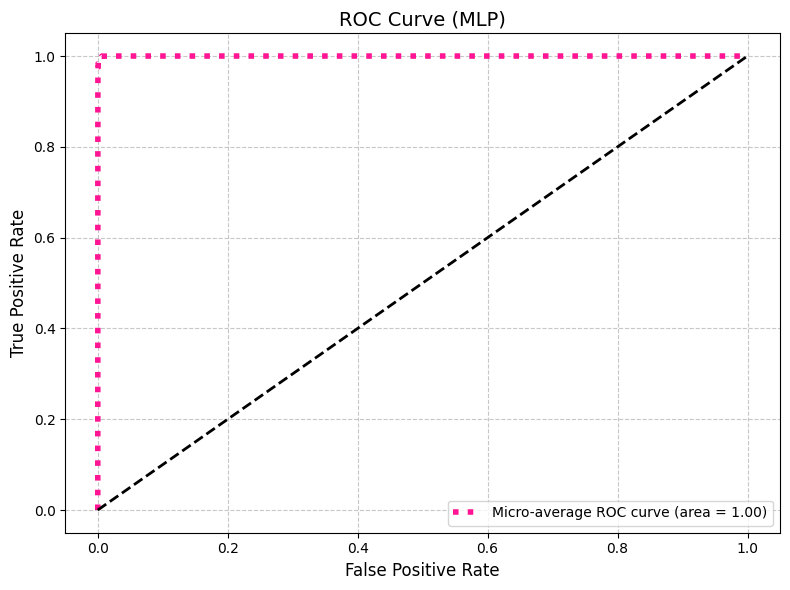


Additional Insights:
Number of epochs trained: 350
Final learning rate: 2.69e-05
The model seems to be well-balanced.
Model saved successfully to ../emotion-predictor/backend/app/model\emotion_model.h5
Scaler saved successfully to ../emotion-predictor/backend/app/model\mpl_scaler.pkl
Label Encoder saved successfully to ../emotion-predictor/backend/app/model\label_encoder.pkl


c:\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load and preprocess data
data = pd.read_csv('final_dataset.csv')

# Separate features and labels
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Normalize input features to [0, 1] range
X = X / 255.0 

# 3. Label encoding : Converts categorical labels in y to numerical form starting from 0
le = LabelEncoder()
y = le.fit_transform(y)

# 4. Split the data into training and test sets with stratification ( 20% test set and 80% training set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Scale features y removing the mean and scaling to unit variance - Helps the model converge faster and improves performance.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Load the best hyperparameters (from previous tuning - grid search)
best_hyperparams = {
    "num_layers": 3,
    "units": 512,
    "dropout_rate": 0.20502924726067387,
    "learning_rate": 0.00021543090477964383,
    "l1_reg": 4.1546327889531985e-05,
    "l2_reg": 1.4496373911843364e-07,
    "epochs": 350,
    "batch_size": 32
}

print("\nBest Hyperparameters:")
for key, value in best_hyperparams.items():
    print(f"{key}: {value}")

# 7. Define the model creation function 
def create_model(num_layers=1, units=64, dropout_rate=0.0, learning_rate=0.001, l1_reg=0.0, l2_reg=0.0):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    for _ in range(num_layers):
        model.add(Dense(units=units, activation='relu',
                        kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(len(np.unique(y)), activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']) # metric in the training accuracy
    return model

# 8. Implement k-fold cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nFold {fold}")
    
    # Split the data for the current fold
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
    
    # Calls "create_mode" with the best hyperparameters
    model = create_model(
        num_layers=best_hyperparams['num_layers'],
        units=best_hyperparams['units'],
        dropout_rate=best_hyperparams['dropout_rate'],
        learning_rate=best_hyperparams['learning_rate'],
        l1_reg=best_hyperparams['l1_reg'],
        l2_reg=best_hyperparams['l2_reg']
    )
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True) # stop training if val_loss doesn't improve after 30 epochs
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, cooldown=5) # Reduces learning rate if val_loss plateaus
    callbacks = [early_stopping, reduce_lr]
    
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=best_hyperparams['epochs'],
        batch_size=best_hyperparams['batch_size'],
        validation_data=(X_val_fold, y_val_fold),
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate the model
    val_pred = model.predict(X_val_fold).argmax(axis=1)
    val_acc = accuracy_score(y_val_fold, val_pred)
    cv_scores.append(val_acc)
    
    print(f"Fold {fold} Validation Accuracy: {val_acc:.4f}")

print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

# 9. Train the final model on the entire training set
final_model = create_model(
    num_layers=best_hyperparams['num_layers'],
    units=best_hyperparams['units'],
    dropout_rate=best_hyperparams['dropout_rate'],
    learning_rate=best_hyperparams['learning_rate'],
    l1_reg=best_hyperparams['l1_reg'],
    l2_reg=best_hyperparams['l2_reg']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, cooldown=5)
callbacks = [early_stopping, reduce_lr]

history = final_model.fit(
    X_train, y_train,
    epochs=best_hyperparams['epochs'],
    batch_size=best_hyperparams['batch_size'],
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# 10. Plot training and validation accuracy/loss
plt.figure(figsize=(15, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.title('Training and Validation Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.title('Training and Validation Loss', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 11. Evaluate the final model on the test set and train set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

train_loss, train_accuracy = final_model.evaluate(X_train, y_train, verbose=0)
print(f"Train Accuracy: {train_accuracy:.4f}")

from sklearn.metrics import f1_score

# Calculate F1-score
y_pred = final_model.predict(X_test).argmax(axis=1)
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Test F1-score: {test_f1:.4f}")

# Calculate precision and recall
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# 12. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, 
            annot=True,        
            fmt='d',           
            cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix (MLP)', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# 13. ROC Curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC curve
y_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_bin.shape[1]

# Get the predicted probabilities
y_score = final_model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve (MLP)', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 14. Additional insights
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
acc_diff = train_acc - val_acc

print("\nAdditional Insights:")
print(f"Number of epochs trained: {len(history.history['accuracy'])}")
print(f"Final learning rate: {final_model.optimizer.learning_rate.numpy():.2e}")

# Check for overfitting/underfitting
if acc_diff > 0.05:
    print("The model might be overfitting.")
elif acc_diff < -0.05:
    print("The model might be underfitting.")
else:
    print("The model seems to be well-balanced.")